##Customer Churn##

Credits: Forked from [growth-workshop](https://github.com/aprial/growth-workshop) by [aprial](https://github.com/aprial), as featured on the [yhat blog](http://blog.yhathq.com/posts/predicting-customer-churn-with-sklearn.html)


"Churn Rate" is a business term describing the rate at which customers leave or cease paying for a product or service. It's a critical figure in many businesses, as it's often the case that acquiring new customers is a lot more costly than retaining existing ones (in some cases, 5 to 20 times more expensive).

Understanding what keeps customers engaged, therefore, is incredibly valuable, as it is a logical foundation from which to develop retention strategies and roll out operational practices aimed to keep customers from walking out the door. Consequently, there's growing interest among companies to develop better churn-detection techniques, leading many to look to data mining and machine learning for new and creative approaches.

Predicting churn is particularly important for businesses w/ subscription models such as cell phone, cable, or merchant credit card processing plans. But modeling churn has wide reaching applications in many domains. For example, casinos have used predictive models to predict ideal room conditions for keeping patrons at the blackjack table and when to reward unlucky gamblers with front row seats to Celine Dion. Similarly, airlines may offer first class upgrades to complaining customers. The list goes on.

Wait, don't go!

So what are some of ops strategies that companies employ to prevent churn? Well, reducing churn, it turns out, often requires non-trivial resources. Specialized retention teams are common in many industries and exist expressly to call down lists of at-risk customers to plead for their continued business.

![](http://blog.yhathq.com/static/img/netflix.png)

Organizing and running such teams is tough. From an ops perspective, cross-geographic teams must be well organized and trained to respond to a huge spectrum of customer complaints. Customers must be accurately targeted based on churn-risk, and retention treatments must be well-conceived and correspond reasonably to match expected customer value to ensure the economics make sense. Spending $1,000 on someone who wasn't about to leave can get expensive pretty quickly.

Within this frame of mind, efficiently dealing with turnover is an exercise of distinguishing who is likely to churn from who is not using the data at our disposal. The remainder of this post will explore a simple case study to show how Python and its scientific libraries can be used to predict churn and how you might deploy such a solution within operations to guide a retention team.

##The Dataset##

The data set we'll be using is a longstanding telecom customer data set.

The data is straightforward. Each row represents a subscribing telephone customer. Each column contains customer attributes such as phone number, call minutes used during different times of day, charges incurred for services, lifetime account duration, and whether or not the customer is still a customer.

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline 

In [2]:
churn_df = pd.read_csv('churn.csv')
col_names = churn_df.columns.tolist()

print("Column names:")
print(col_names)

to_show = col_names[:6] + col_names[-6:]

print("\nSample data:")
churn_df[to_show].head(6)
      

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:


State  Account Length  Area Code     Phone Int'l Plan VMail Plan   
0    KS             128        415  382-4657         no        yes  \
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   
5    AL             118        510  391-8027        yes         no   

   Night Charge  Intl Mins  Intl Calls  Intl Charge  CustServ Calls  Churn?  
0         11.01       10.0           3         2.70               1  False.  
1         11.45       13.7           3         3.70               1  False.  
2          7.32       12.2           5         3.29               0  False.  
3          8.86        6.6           7         1.78               2  False.  
4          8.41       10.1           3         2.73               3  False.  
5          9.18        6.3           6         1.70               0  False.

We'll be keeping the statistical model pretty simple for this example so the feature space is almost unchanged from what you see above. The following code simply drops irrelevant columns and converts strings to boolean values (since models don't handle "yes" and "no" very well). The rest of the numeric columns are left untouched.

In [5]:
# Isolate target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True',1,0)
print(y)

[0 0 0 ... 0 0 0]


In [6]:
# We don't need these columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

In [7]:
# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
# yes_no_cols = ["Int'l Plan","VMail Plan"]
# churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

churn_feat_space["Int'l Plan"] = churn_feat_space["Int'l Plan"].map(
                   {'yes':1 ,'no':0})

print(churn_feat_space)

      Account Length  Int'l Plan VMail Plan  VMail Message  Day Mins   
0                128           0        yes             25     265.1  \
1                107           0        yes             26     161.6   
2                137           0         no              0     243.4   
3                 84           1         no              0     299.4   
4                 75           1         no              0     166.7   
...              ...         ...        ...            ...       ...   
3328             192           0        yes             36     156.2   
3329              68           0         no              0     231.1   
3330              28           0         no              0     180.8   
3331             184           1         no              0     213.8   
3332              74           0        yes             25     234.4   

      Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins   
0           110       45.07     197.4         99       16.7

In [8]:
# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
# yes_no_cols = ["Int'l Plan","VMail Plan"]
# churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

churn_feat_space["VMail Plan"] = churn_feat_space["VMail Plan"].map(
                   {'yes':1 ,'no':0})

print(churn_feat_space)

      Account Length  Int'l Plan  VMail Plan  VMail Message  Day Mins   
0                128           0           1             25     265.1  \
1                107           0           1             26     161.6   
2                137           0           0              0     243.4   
3                 84           1           0              0     299.4   
4                 75           1           0              0     166.7   
...              ...         ...         ...            ...       ...   
3328             192           0           1             36     156.2   
3329              68           0           0              0     231.1   
3330              28           0           0              0     180.8   
3331             184           1           0              0     213.8   
3332              74           0           1             25     234.4   

      Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins   
0           110       45.07     197.4         9

In [9]:
# Pull out features for future use
features = churn_feat_space.columns
print(features)

Index(['Account Length', 'Int'l Plan', 'VMail Plan', 'VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')


In [10]:
print(churn_feat_space)


      Account Length  Int'l Plan  VMail Plan  VMail Message  Day Mins   
0                128           0           1             25     265.1  \
1                107           0           1             26     161.6   
2                137           0           0              0     243.4   
3                 84           1           0              0     299.4   
4                 75           1           0              0     166.7   
...              ...         ...         ...            ...       ...   
3328             192           0           1             36     156.2   
3329              68           0           0              0     231.1   
3330              28           0           0              0     180.8   
3331             184           1           0              0     213.8   
3332              74           0           1             25     234.4   

      Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins   
0           110       45.07     197.4         9

In [18]:
X = churn_feat_space.values.astype(np.float)

# This is important
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))
      

Feature space holds 3333 observations and 17 features
Unique target labels: [0]


C:\Users\User\AppData\Local\Temp\ipykernel_38308\920020132.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = churn_feat_space.values.astype(np.float)


Some images!!!

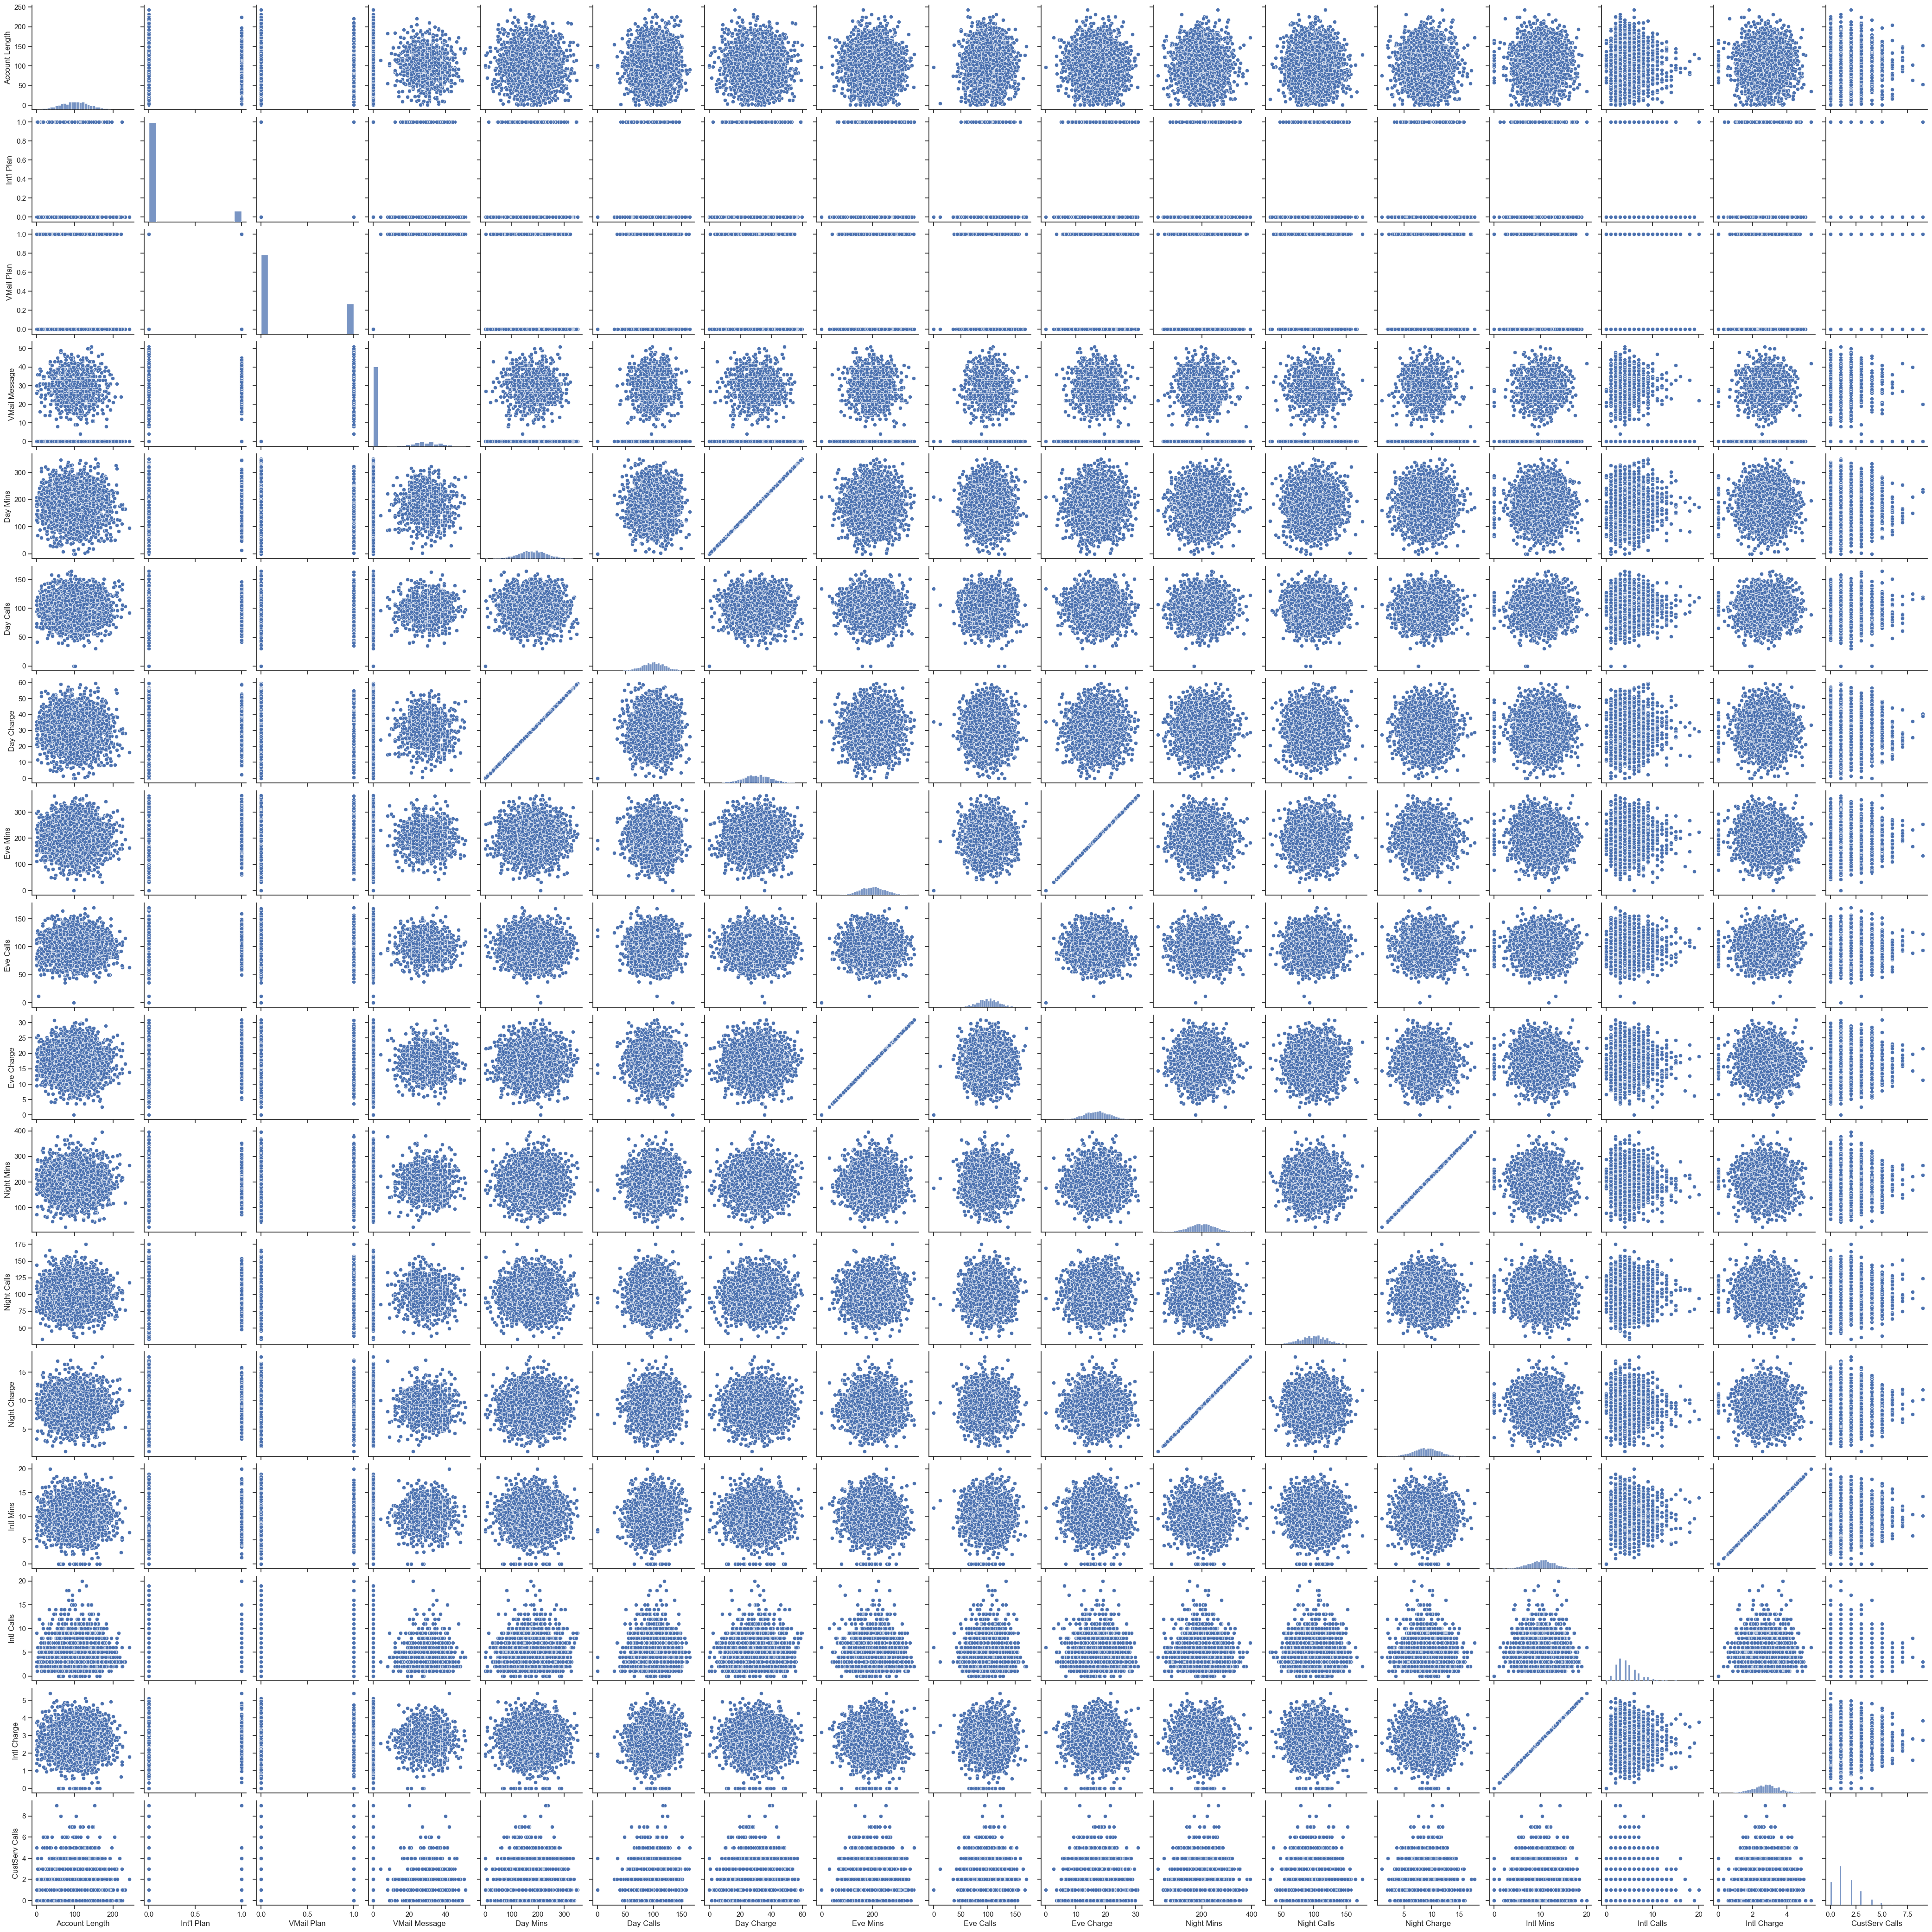

In [19]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(churn_feat_space)


import matplotlib.pyplot as plt
plt.show()

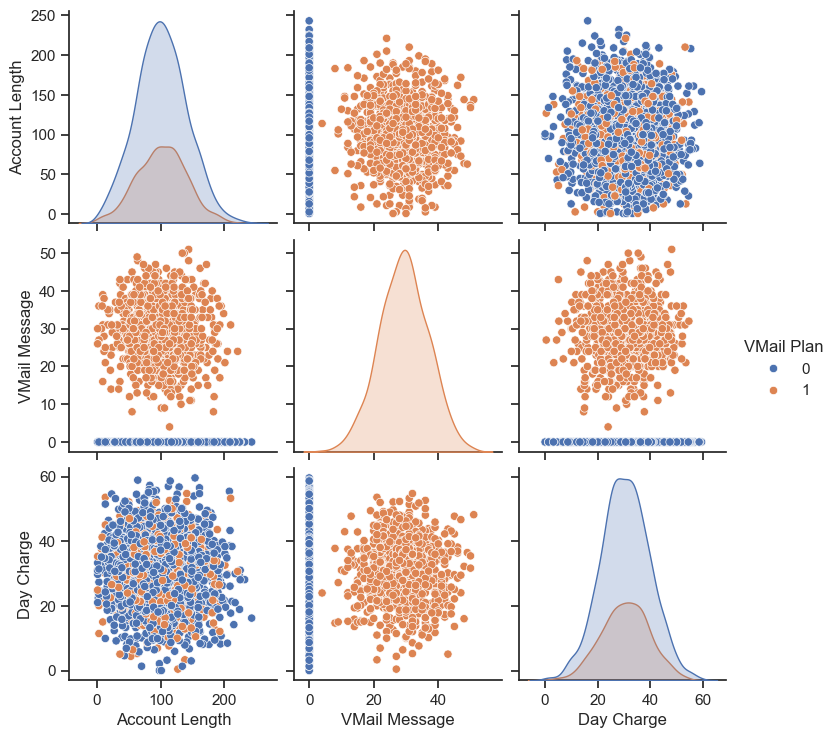

In [20]:
sns.pairplot(churn_feat_space, hue='VMail Plan', vars=['Account Length', 'VMail Message', 'Day Charge'])   
plt.show()

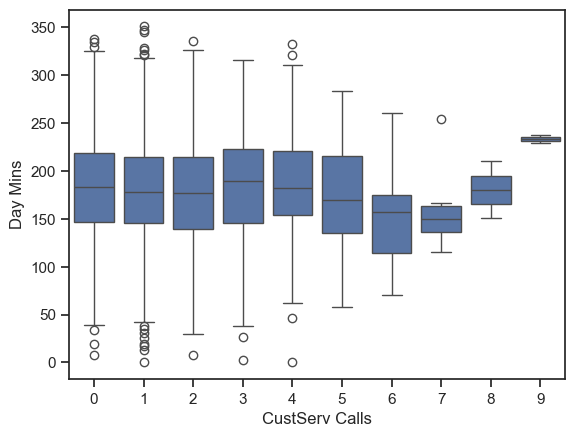

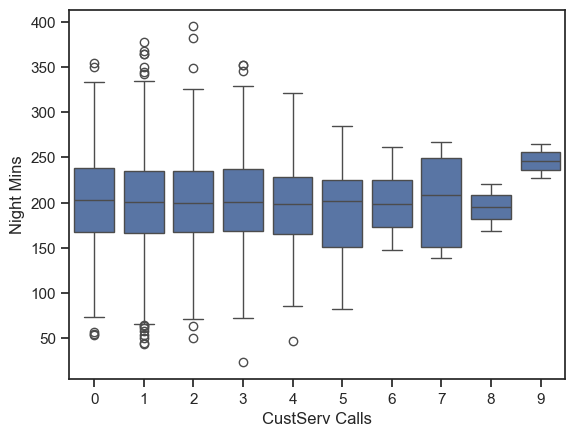

In [21]:
# Usual boxplot
sns.boxplot(x='CustServ Calls', y='Day Mins', data=churn_feat_space)
plt.show()

# boxplot
sns.boxplot(x='CustServ Calls', y='Night Mins', data=churn_feat_space)
plt.show()

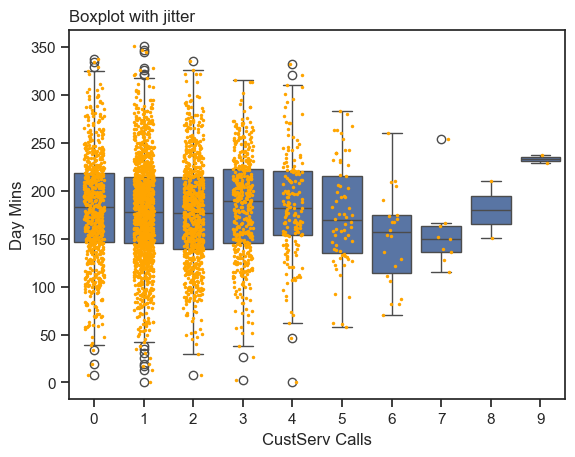

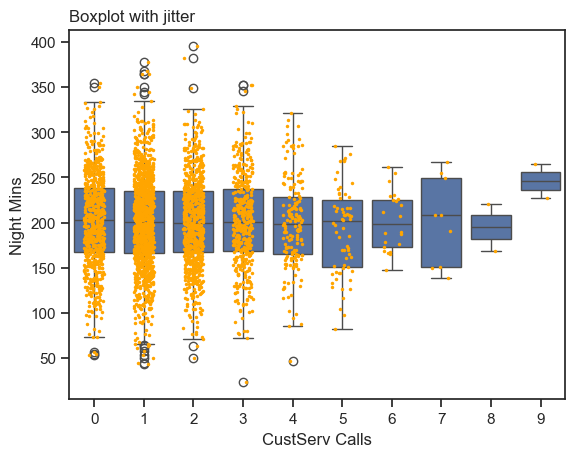

In [22]:
# Usual boxplot
sns.boxplot(x='CustServ Calls', y='Day Mins', data=churn_feat_space)

# add stripplot
ax = sns.stripplot(x='CustServ Calls', y='Day Mins', data=churn_feat_space, color="orange", jitter=0.2, size=2.5)

# add title
plt.title("Boxplot with jitter", loc="left")

# show the graph
plt.show()


# Usual boxplot
sns.boxplot(x='CustServ Calls', y='Night Mins', data=churn_feat_space)

# add stripplot
ax = sns.stripplot(x='CustServ Calls', y='Night Mins', data=churn_feat_space, color="orange", jitter=0.2, size=2.5)

# add title
plt.title("Boxplot with jitter", loc="left")

# show the graph
plt.show()

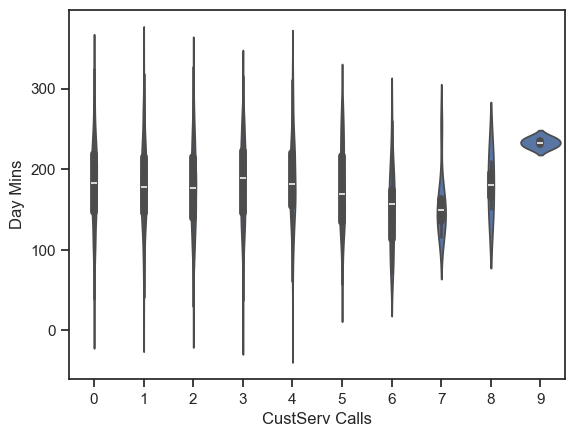

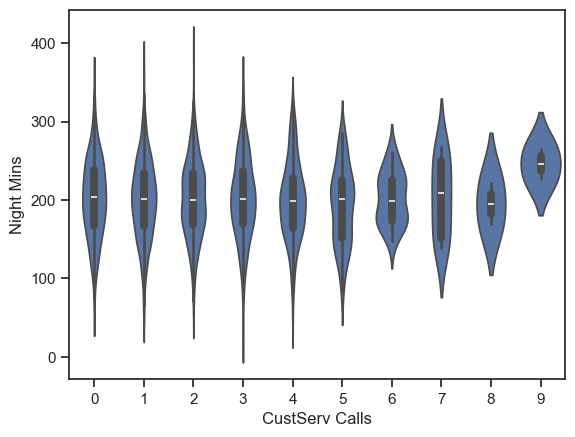

In [23]:
# Usual boxplot
sns.violinplot(x='CustServ Calls', y='Day Mins', data=churn_feat_space)
plt.show()

# boxplot
sns.violinplot(x='CustServ Calls', y='Night Mins', data=churn_feat_space)
plt.show()

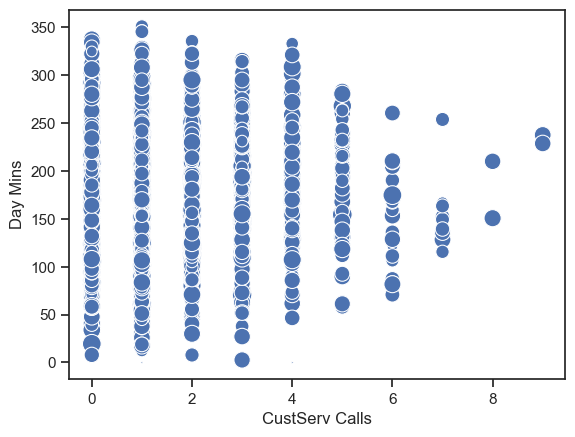

In [24]:
# use the scatterplot function to build the bubble map
sns.scatterplot(data=churn_feat_space, x="CustServ Calls", y="Day Mins", size="Day Calls", legend=False, sizes=(2, 200))

# show the graph
plt.show()

In [77]:
churn_feat_space = churn_feat_space.head(100)

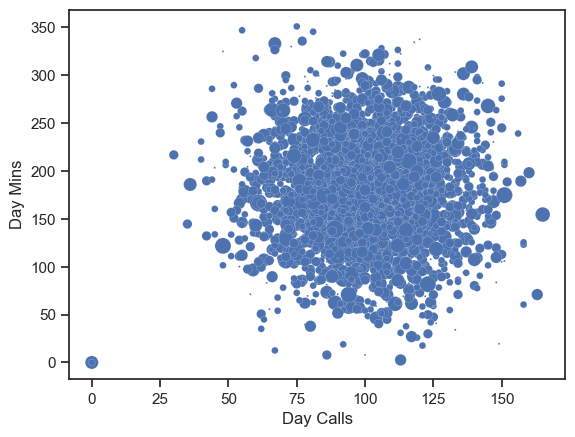

In [25]:
# use the scatterplot function to build the bubble map
sns.scatterplot(data=churn_feat_space, x="Day Calls", y="Day Mins", size="CustServ Calls", legend=False, sizes=(2, 200))

# show the graph
plt.show()

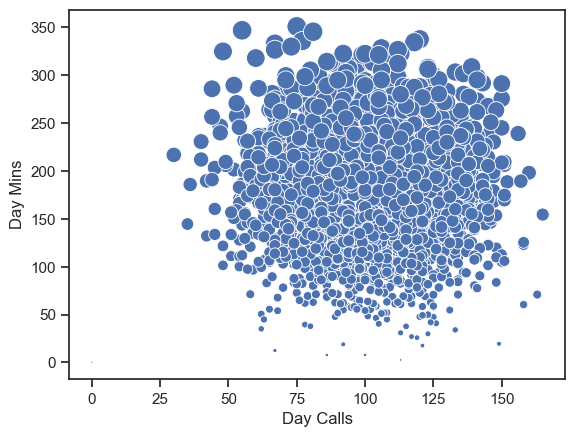

In [26]:
# use the scatterplot function to build the bubble map
sns.scatterplot(data=churn_feat_space, x="Day Calls", y="Day Mins", size="Day Mins", legend=False, sizes=(2, 200))

# show the graph
plt.show()

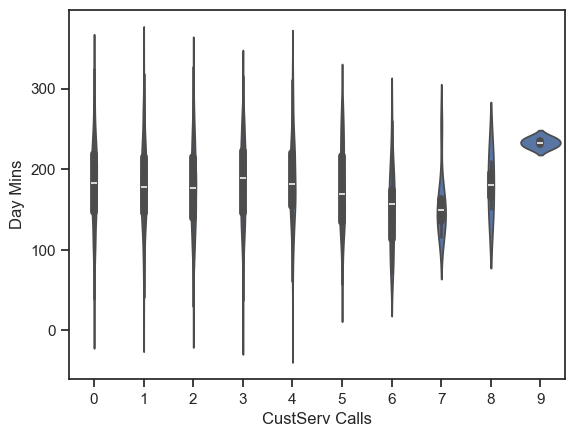

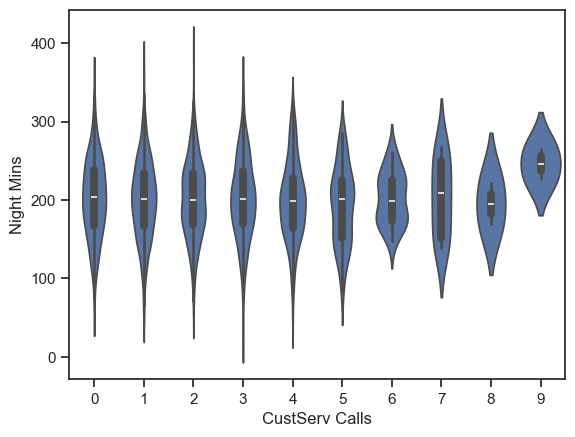

In [27]:
# Usual boxplot
sns.violinplot(x='CustServ Calls', y='Day Mins', data=churn_feat_space)
plt.show()

# boxplot
sns.violinplot(x='CustServ Calls', y='Night Mins', data=churn_feat_space)
plt.show()

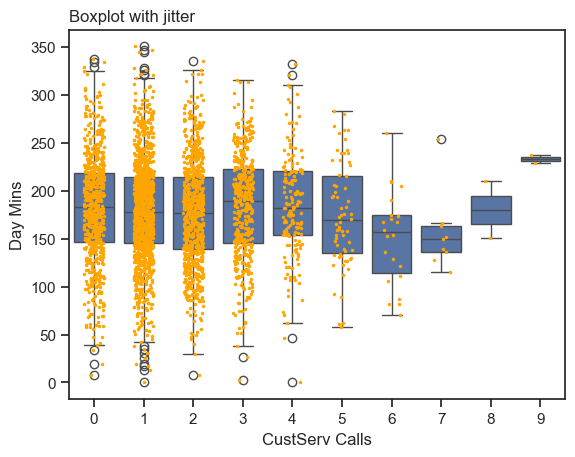

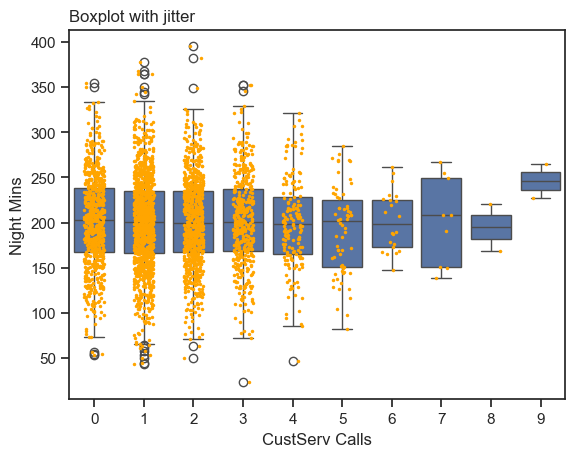

In [28]:
# Usual boxplot
sns.boxplot(x='CustServ Calls', y='Day Mins', data=churn_feat_space)

# add stripplot
ax = sns.stripplot(x='CustServ Calls', y='Day Mins', data=churn_feat_space, color="orange", jitter=0.2, size=2.5)

# add title
plt.title("Boxplot with jitter", loc="left")

# show the graph
plt.show()


# Usual boxplot
sns.boxplot(x='CustServ Calls', y='Night Mins', data=churn_feat_space)

# add stripplot
ax = sns.stripplot(x='CustServ Calls', y='Night Mins', data=churn_feat_space, color="orange", jitter=0.2, size=2.5)

# add title
plt.title("Boxplot with jitter", loc="left")

# show the graph
plt.show()

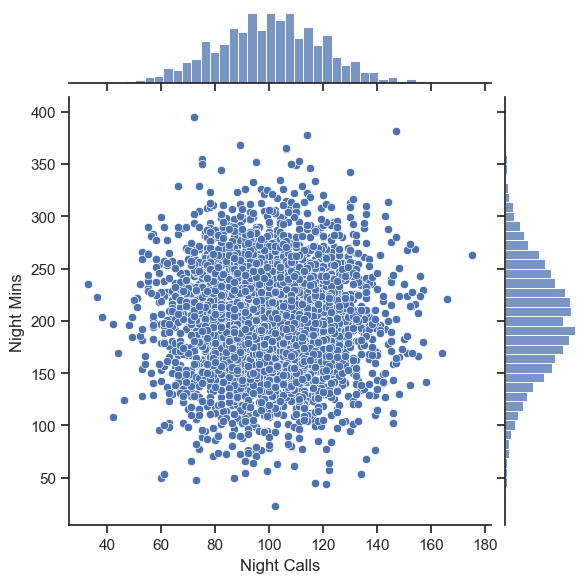

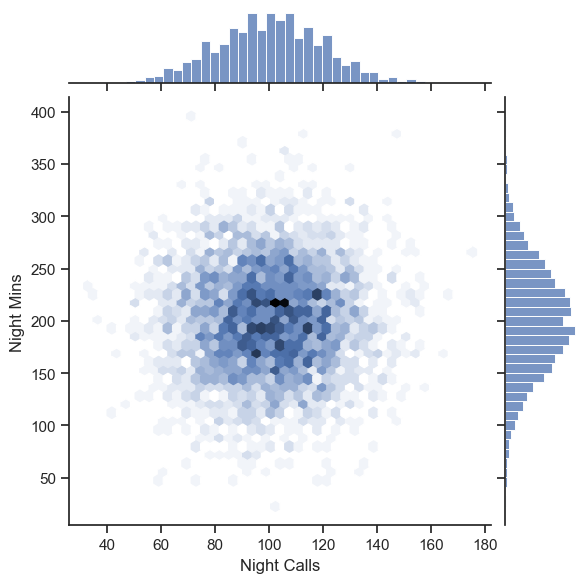

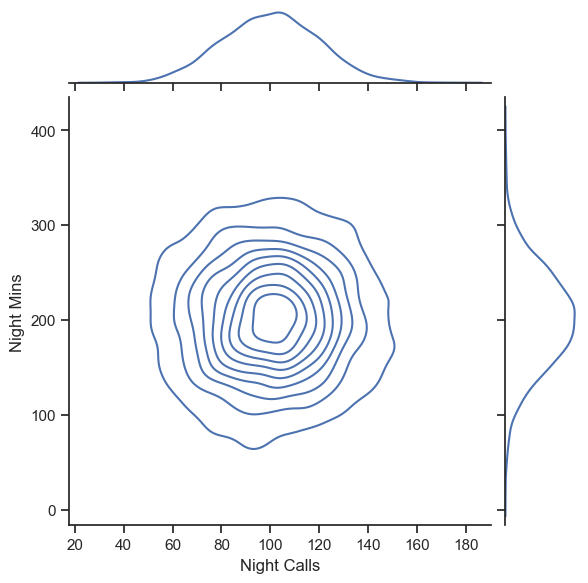

In [29]:
# Custom the inside plot: options are: “scatter” | “reg” | “resid” | “kde” | “hex”
sns.jointplot(x=churn_feat_space["Night Calls"], y=churn_feat_space["Night Mins"], kind='scatter')
sns.jointplot(x=churn_feat_space["Night Calls"], y=churn_feat_space["Night Mins"], kind='hex')
sns.jointplot(x=churn_feat_space["Night Calls"], y=churn_feat_space["Night Mins"], kind='kde')

plt.show()

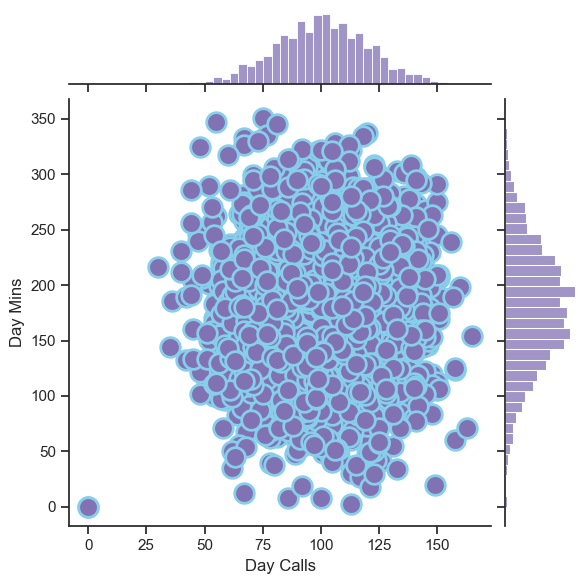

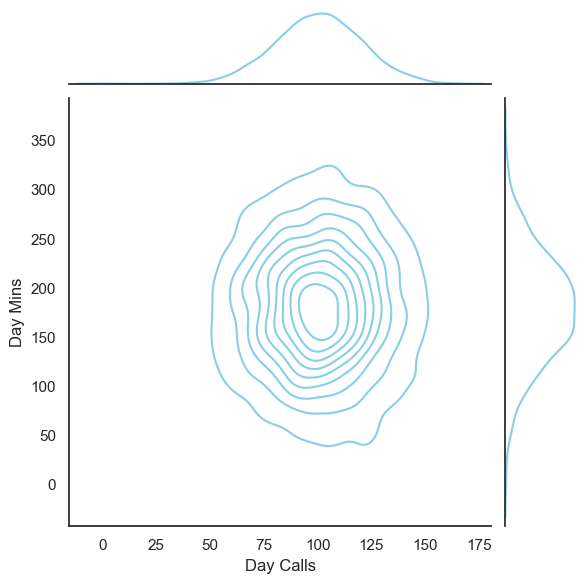

In [30]:
# Then you can pass arguments to each type:
sns.jointplot(x=churn_feat_space["Day Calls"], y=churn_feat_space["Day Mins"], kind='scatter', s=200, color='m', edgecolor="skyblue", linewidth=2)
 
# Custom the color
sns.set(style="white", color_codes=True)
sns.jointplot(x=churn_feat_space["Day Calls"], y=churn_feat_space["Day Mins"], kind='kde', color="skyblue")

plt.show()

In [31]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

vars = ['Day Calls', 'Day Mins', 'Night Calls', 'Night Mins']
fig = make_subplots(rows=1, cols=len(vars))
for i, var in enumerate(vars):
    fig.add_trace(
        go.Box(y=churn_feat_space[var],
        name=var),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

In [32]:
churn_df = churn_df.head(100)
print(churn_df)

   State  Account Length  Area Code     Phone Int'l Plan VMail Plan   
0     KS             128        415  382-4657         no        yes  \
1     OH             107        415  371-7191         no        yes   
2     NJ             137        415  358-1921         no         no   
3     OH              84        408  375-9999        yes         no   
4     OK              75        415  330-6626        yes         no   
..   ...             ...        ...       ...        ...        ...   
95    AK             104        408  366-4467         no         no   
96    MT              73        415  370-3450         no         no   
97    AZ              99        415  327-3954         no         no   
98    MS             120        408  355-6291         no         no   
99    ID              77        415  362-9748         no         no   

    VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls   
0              25     265.1        110       45.07  ...         99  \
1      

In [33]:
import plotly.express as px
churn_df = churn_df.head(100)
fig = px.scatter(churn_df,
                x='Night Calls',
                y='Day Calls',
                hover_name='State',
                title='Night Calls vs. Day Calls')
fig.show()

In [34]:
import plotly.express as px
fig = px.scatter(churn_df,  x="Day Calls", y="Day Mins", color="State",
                 size='Day Calls', hover_data=['State'])
fig.show() 